# Проект для «Викишоп»

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Значение метрики качества *F1* должно быть не меньше 0.75. 

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch
import transformers
import re
from tqdm import notebook
import nltk
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

In [4]:
rand=12345

In [5]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv').drop('Unnamed: 0', axis=1)

In [6]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


Загрузим словарь

In [7]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Подготовим функции для лемматизации и очистки текста

In [8]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
def lemmatize(text):
    m = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemm_text = " ".join([m.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    return lemm_text

In [10]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())

In [11]:
from tqdm.notebook import tqdm
tqdm.pandas()

Лемматизируем и очистим текст

In [12]:
data['text'] = data['text'].progress_apply(lambda x: lemmatize(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [13]:
data['text'] = data['text'].progress_apply(lambda x: clear_text(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [14]:
data

,text,toxic
0,Explanation Why the edits make under my userna...,0
1,D aww He match this background colour I m seem...,0
2,Hey man I m really not try to edit war It s ju...,0
3,More I ca n t make any real suggestion on impr...,0
4,You sir be my hero Any chance you remember wha...,0
...,...,...
159287,And for the second time of ask when your view ...,0
159288,You should be ashamed of yourself That be a ho...,0
159289,Spitzer Umm there no actual article for prosti...,0
159290,And it look like it be actually you who put on...,0


In [15]:
!/opt/conda/bin/python -m pip install wordcloud 

In [16]:
!pip install --upgrade Pillow

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


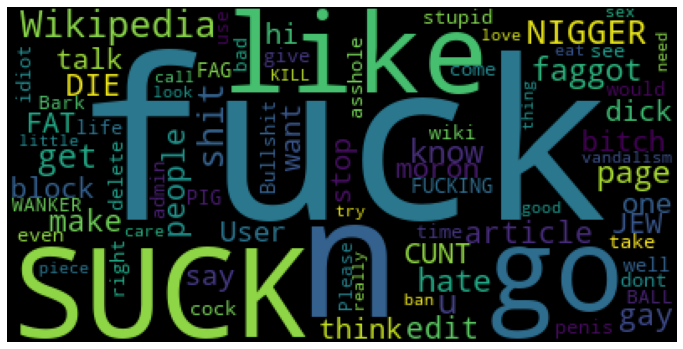

In [19]:
df_negative = data[data['toxic'] == 1]
text_cloud = ' '.join(df_negative['text'])
cloud = WordCloud(stopwords=stopwords, max_words=80, collocations=False).generate(text_cloud)
plt.figure(figsize=(12,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()   

В токсичных комментариях наиболее популярны ругательства

Сделаем словарь стоп-слов

Рассчитаем TF-IDF для текстов

In [20]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=rand, stratify=data['toxic'])

In [21]:
features_train = data_train['text']
target_train = data_train['toxic']
features_test = data_test['text']
target_test = data_test['toxic']

## Обучение

Рассмотрим несколько моделей классификации и выберем лучшую через пайплайн

In [22]:
params_1={'model__n_estimators':[50, 100],
            'model__max_depth':[5, 10]}
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),

    ('model', RandomForestClassifier(random_state=rand, class_weight='balanced'))

    ])


grid_pipeline_1 = GridSearchCV(pipeline_1, cv=3, param_grid=params_1, scoring='f1', verbose=5)
grid_pipeline_1.fit(features_train, target_train)
print(f'Лучшая Метрика на кросс валидации {grid_pipeline_1.best_score_}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .....model__max_depth=5, model__n_estimators=50; total time=   7.0s
[CV 2/3] END .....model__max_depth=5, model__n_estimators=50; total time=   7.5s
[CV 3/3] END .....model__max_depth=5, model__n_estimators=50; total time=   7.4s
[CV 1/3] END ....model__max_depth=5, model__n_estimators=100; total time=   8.3s
[CV 2/3] END ....model__max_depth=5, model__n_estimators=100; total time=   8.1s
[CV 3/3] END ....model__max_depth=5, model__n_estimators=100; total time=   8.4s
[CV 1/3] END ....model__max_depth=10, model__n_estimators=50; total time=   7.9s
[CV 2/3] END ....model__max_depth=10, model__n_estimators=50; total time=   7.7s
[CV 3/3] END ....model__max_depth=10, model__n_estimators=50; total time=   7.9s
[CV 1/3] END ...model__max_depth=10, model__n_estimators=100; total time=   9.6s
[CV 2/3] END ...model__max_depth=10, model__n_estimators=100; total time=   9.4s
[CV 3/3] END ...model__max_depth=10, model__n_est

In [23]:
params_2={'model__C':[.1,.5,1,5]
            }
pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),

    ('model', LogisticRegression(random_state = rand))

    ])


grid_pipeline_2 = GridSearchCV(pipeline_2, cv=3, param_grid=params_2, scoring='f1', verbose=5)
grid_pipeline_2.fit(features_train, target_train)
print(f'Лучшая Метрика на кросс валидации {grid_pipeline_2.best_score_}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ...................................model__C=0.1; total time=  28.7s
[CV 2/3] END ...................................model__C=0.1; total time=  25.8s
[CV 3/3] END ...................................model__C=0.1; total time=  22.9s
[CV 1/3] END ...................................model__C=0.5; total time=  39.0s
[CV 2/3] END ...................................model__C=0.5; total time=  41.4s
[CV 3/3] END ...................................model__C=0.5; total time=  42.6s
[CV 1/3] END .....................................model__C=1; total time=  48.8s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END .....................................model__C=1; total time=  46.1s
[CV 3/3] END .....................................model__C=1; total time=  45.3s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END .....................................model__C=5; total time=  46.9s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END .....................................model__C=5; total time=  48.4s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END .....................................model__C=5; total time=  46.1s
Лучшая Метрика на кросс валидации 0.7590132210740599


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
params_3={'model__n_estimators':[50, 100],
            'model__max_depth':[5, 10]}
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),

    ('model', lgb.LGBMClassifier(random_state=rand, learning_rate=0.01))

    ])


grid_pipeline_3 = GridSearchCV(pipeline_3, cv=3, param_grid=params_3, scoring='f1', verbose=5)
grid_pipeline_3.fit(features_train, target_train)
print(f'Лучшая Метрика на кросс валидации {grid_pipeline_3.best_score_}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .....model__max_depth=5, model__n_estimators=50; total time=  42.6s
[CV 2/3] END .....model__max_depth=5, model__n_estimators=50; total time=  42.3s
[CV 3/3] END .....model__max_depth=5, model__n_estimators=50; total time=  44.3s
[CV 1/3] END ....model__max_depth=5, model__n_estimators=100; total time= 1.0min
[CV 2/3] END ....model__max_depth=5, model__n_estimators=100; total time=  58.8s
[CV 3/3] END ....model__max_depth=5, model__n_estimators=100; total time=  57.9s
[CV 1/3] END ....model__max_depth=10, model__n_estimators=50; total time=  50.8s
[CV 2/3] END ....model__max_depth=10, model__n_estimators=50; total time=  53.8s
[CV 3/3] END ....model__max_depth=10, model__n_estimators=50; total time=  55.3s
[CV 1/3] END ...model__max_depth=10, model__n_estimators=100; total time= 1.4min
[CV 2/3] END ...model__max_depth=10, model__n_estimators=100; total time= 1.4min
[CV 3/3] END ...model__max_depth=10, model__n_est

Лучший результат на тренировочной выборке показывает LogisticRegression

In [25]:
prediction = grid_pipeline_2.best_estimator_.predict(features_test)

In [26]:
print('F1', (f1_score(target_test, prediction)))

F1 0.7696842105263157


Удалось достичь результата больше 0.75

## Выводы

- Проведена лемматизация и очистка текстов комментариев
- В качестве признака посчитан и взят параметр TF-IDF
- С помощью пайплайна рассмотрено несколько моделей классификации, наилучший результат показала логистическая регрессия
- Результат на тестовой выборке - 0.769